In [1]:
#import libraries
import pandas as pd
from ast import literal_eval
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report, recall_score, precision_score
import numpy as np
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

Since we will be trying a number of different models, we decided to create a function that will store all of the outcomes of interest in a dictionary. The function below does an 80/20 train/test split. We also fit all of our models using a 50/50 split, but had better accuracy when using 80/20.

In [2]:
def evaluate_model(model, predictors, response, cv=False, params=None):
    """
    evaluate_model()
    
    -splits the predictors & response variables into train and test sets. 
    -creates a dictionary of model outcomes that are of interest
    -if specified, this function will use cross-validation to determine the optimal parameters for a given model
    
    inputs:
        -model: a model object to be fitted
        -predictors: an array, series, or dataframe of predictor variable(s)
        -response: an array or series of the response variable
        -cv: whether or not to cross-validate the model's parameters (default=False)
        -params: if cv=True, params are required to indicate what parameters to optimize in the given model (default=None)
        
    outputs:
        -a results dictionary containing the following:
            -a fitted model object
    
    """
    results = {}
    train_x, test_x = train_test_split(predictors, test_size=0.2, random_state=9001)
    train_y, test_y = train_test_split(response, test_size=0.2, random_state=9001)
    
    if cv:
        model = GridSearchCV(model, params, scoring=make_scorer(f1_score, average='micro'))
    
    classif = OneVsRestClassifier(model)
    classif.fit(train_x, train_y)
    
    train_yhat = classif.predict(train_x)
    test_yhat = classif.predict(test_x)
    
    results['fitted_model'] = classif
    
    results['train_yhat'] = train_yhat
    results['test_yhat'] = test_yhat
    
    results['train_recall_score'] = recall_score(train_y, train_yhat, average='weighted')
    results['test_recall_score'] = recall_score(test_y, test_yhat, average='weighted')
    
    results['train_precision_score'] = precision_score(train_y, train_yhat,average='weighted')
    results['test_precision_score'] = precision_score(test_y, test_yhat,average='weighted')
    
    results['train_classification_report'] = classification_report(train_y, train_yhat,target_names=target_names)
    results['test_classification_report'] = classification_report(test_y, test_yhat,target_names=target_names)
    
    return results

In [3]:
import json

In [4]:
target_names = json.load(open('target_names.json'))

target_names

['Action',
 'Adventure',
 'Animation',
 'Biography',
 'Comedy',
 'Crime',
 'Drama',
 'Family',
 'Fantasy',
 'Film-Noir',
 'History',
 'Horror',
 'Music',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Sport',
 'Thriller',
 'War',
 'Western']

Next we will load in our arrays to be used as predictor variables.

In [5]:
lemmatized_bow = np.load('lemmatized_bow.npy')

Our Word2Vector and Docs2Vector arrays require 2 additional steps in order to be used as predictors:

    1: They need to be converted to an array of lists (they are currently an array of arrays, which is incompatible with the structure of the response variable, which is also an array of lists).
    2: The values need to be standardized between 0 and 1, because (todo - there was an error when they were negative. I will have to re-run and see what caused the error

In [6]:
w2v_mean = np.load('w2v_mean.npy', allow_pickle=True)

doc_vec = np.load('final_text2_doc_vec.npy', allow_pickle=True)

w2v_mean_value = np.apply_along_axis(lambda x: list(x), 0, w2v_mean)

doc_vec_value = np.apply_along_axis(lambda x: list(x), 0, doc_vec)


In [7]:
from sklearn.preprocessing import MinMaxScaler
scale = MinMaxScaler()


#word2vec scaling
scale.fit(w2v_mean_value)
scaled_w2v_mean = scale.transform(w2v_mean_value)


#doc2vec scaling
scale.fit(doc_vec_value)
scaled_doc_vec = scale.transform(doc_vec_value)


Load in response variable

In [8]:
binary_tmdb = np.load('binarized_data.npy')

In [10]:
modelDict = {'Naive-Bayes':{'model':MultinomialNB(),
                           'params':{'alpha':[0.01,0.1,1.0]}},
            
            'KNN':{'model':KNeighborsClassifier(metric = 'minkowski'),
                   'params':{'n_neighbors':[4,5,7,9]}},
            
            'SVC':{'model':SVC(class_weight='balanced', kernel='linear'),
                   'params':{'C':[0.01,0.1,1.0]}}
           }

predictorDict = {
                 'movie_bow':lemmatized_bow,
                 
                 'movie_w2v_mean':scaled_w2v_mean,
               
                 'movie_doc_vec':scaled_doc_vec,
}

sklearn returns a warning when the function above uses weighted averages on samples that have no predictors. This will not affect our metrics and outputs repetitive information when run in a loop. The warning, that we are choosing to ignore, is as follows:

```UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)```

In [11]:
resultsDict = {}
import warnings
with warnings.catch_warnings(): #temporarily ignore the warnings described above
    warnings.simplefilter("ignore")
    for model in modelDict:
        for predictor in predictorDict:
            resultsDict['{0}-{1}'.format(model,predictor)] = evaluate_model(model = modelDict[model]['model'],
                                                                            predictors = predictorDict[predictor], 
                                                                            response = binary_tmdb,
                                                                            cv=True,
                                                                            params=modelDict[model]['params'])

Next we will make a dataframe of the scores for the sake of readability.

In [12]:
scores = ['train_recall_score','test_recall_score',
          'train_precision_score','test_precision_score']

results_df = pd.DataFrame(resultsDict)

In [13]:
results_df

,Naive-Bayes-movie_bow,Naive-Bayes-movie_w2v_mean,Naive-Bayes-movie_doc_vec,KNN-movie_bow,KNN-movie_w2v_mean,KNN-movie_doc_vec,SVC-movie_bow,SVC-movie_w2v_mean,SVC-movie_doc_vec
fitted_model,OneVsRestClassifier(estimator=GridSearchCV(est...,OneVsRestClassifier(estimator=GridSearchCV(est...,OneVsRestClassifier(estimator=GridSearchCV(est...,OneVsRestClassifier(estimator=GridSearchCV(est...,OneVsRestClassifier(estimator=GridSearchCV(est...,OneVsRestClassifier(estimator=GridSearchCV(est...,OneVsRestClassifier(estimator=GridSearchCV(est...,OneVsRestClassifier(estimator=GridSearchCV(est...,OneVsRestClassifier(estimator=GridSearchCV(est...
train_yhat,"[[0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0,...","[[0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,..."
test_yhat,"[[1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0,...","[[1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1,..."
train_recall_score,0.949059,0.21386,0.215695,0.501606,0.418541,0.346489,0.99128,0.685177,0.684718
test_recall_score,0.531194,0.213904,0.213904,0.433155,0.31016,0.272727,0.650624,0.629234,0.677362
train_precision_score,0.936506,0.330067,0.121264,0.782519,0.766685,0.707799,0.912535,0.487589,0.435649
test_precision_score,0.668107,0.260032,0.122231,0.675291,0.545837,0.379157,0.670511,0.479446,0.418123
train_classification_report,precision recall f1-score ...,precision recall f1-score ...,precision recall f1-score ...,precision recall f1-score ...,precision recall f1-score ...,precision recall f1-score ...,precision recall f1-score ...,precision recall f1-score ...,precision recall f1-score ...
test_classification_report,precision recall f1-score ...,precision recall f1-score ...,precision recall f1-score ...,precision recall f1-score ...,precision recall f1-score ...,precision recall f1-score ...,precision recall f1-score ...,precision recall f1-score ...,precision recall f1-score ...


# Accuracy Metrics


**Precision Score, Recall Score:**

As shown in the cell above, we are interested in the precision score as well as the recall score. 


The precision score can be defined as `tp / (tp + fp)`, where `tp` represents true-positives and `fp` represents false-positives.

The recall score can be defined as `tp / (tp + fn)` where `tp` represents true-positives and `fn` represents false-negatives


In other words, the precision score penalizes false-positives, whereas the recall score penalizes false-negatives. Both scores range from 0 to 1, with 1 representing perfect accuracy.


**F1-Score:**

While not included in our results_df dataframe, this outcome is included in the `classification_report`, which is shown a little further below. The F1 score can be defined as:

`F1 = 2 * (precision * recall) / (precision + recall)`

In [14]:
results_df = results_df.loc[results_df.index.isin(scores)]

In [15]:
results_df = results_df.transpose()
results_df

,train_recall_score,test_recall_score,train_precision_score,test_precision_score
Naive-Bayes-movie_bow,0.949059,0.531194,0.936506,0.668107
Naive-Bayes-movie_w2v_mean,0.21386,0.213904,0.330067,0.260032
Naive-Bayes-movie_doc_vec,0.215695,0.213904,0.121264,0.122231
KNN-movie_bow,0.501606,0.433155,0.782519,0.675291
KNN-movie_w2v_mean,0.418541,0.31016,0.766685,0.545837
KNN-movie_doc_vec,0.346489,0.272727,0.707799,0.379157
SVC-movie_bow,0.99128,0.650624,0.912535,0.670511
SVC-movie_w2v_mean,0.685177,0.629234,0.487589,0.479446
SVC-movie_doc_vec,0.684718,0.677362,0.435649,0.418123


In [16]:
duplicate_list = list(results_df.index.values)

In [17]:
duplicate_list

['Naive-Bayes-movie_bow',
 'Naive-Bayes-movie_w2v_mean',
 'Naive-Bayes-movie_doc_vec',
 'KNN-movie_bow',
 'KNN-movie_w2v_mean',
 'KNN-movie_doc_vec',
 'SVC-movie_bow',
 'SVC-movie_w2v_mean',
 'SVC-movie_doc_vec']

In [47]:
print(resultsDict[duplicate_list[0]]['train_classification_report'])
print(resultsDict[duplicate_list[0]]['test_classification_report'])

              precision    recall  f1-score   support

      Action       0.92      0.93      0.92       208
   Adventure       0.84      0.94      0.89       122
   Animation       1.00      1.00      1.00        32
   Biography       1.00      0.33      0.50         3
      Comedy       0.93      0.92      0.92       278
       Crime       0.98      0.99      0.98       156
       Drama       0.94      0.96      0.95       470
      Family       1.00      0.96      0.98        27
     Fantasy       0.99      0.92      0.95        73
   Film-Noir       0.00      0.00      0.00         2
     History       1.00      1.00      1.00         3
      Horror       0.94      0.97      0.96       115
       Music       1.00      1.00      1.00        25
     Mystery       1.00      1.00      1.00        83
     Romance       0.97      0.93      0.95       156
      Sci-Fi       0.93      0.95      0.94       110
       Sport       1.00      0.50      0.67         2
    Thriller       0.91    

Each of these 9 models are being overfit - for both the train and test dataset, each of these models is predicting that 100% of the movies will be genres. This is because of the large number of drama movies in the dataset (this is demonstrated in our EDA notebook). Fine-tuning the penalization parameters may help with these models being overfit, but that exploration is outside the scope of this analysis. We will instead focus on the models that are not being overfit.

# Best Model

The type of the cell values are, by default, non-numeric.

In [40]:
results_df = results_df.apply(pd.to_numeric, errors='coerce')

In [41]:
results_df

,train_recall_score,test_recall_score,train_precision_score,test_precision_score
Naive-Bayes-movie_bow,0.949059,0.531194,0.936506,0.668107
Naive-Bayes-movie_w2v_mean,0.213860,0.213904,0.330067,0.260032
Naive-Bayes-movie_doc_vec,0.215695,0.213904,0.121264,0.122231
KNN-movie_bow,0.501606,0.433155,0.782519,0.675291
KNN-movie_w2v_mean,0.418541,0.310160,0.766685,0.545837
KNN-movie_doc_vec,0.346489,0.272727,0.707799,0.379157
SVC-movie_bow,0.991280,0.650624,0.912535,0.670511
SVC-movie_w2v_mean,0.685177,0.629234,0.487589,0.479446
SVC-movie_doc_vec,0.684718,0.677362,0.435649,0.418123


In [30]:
def f1_score(x, y):
    score = 2 * ((x * y) / (x + y))
    return score

In [44]:
results_df['test_f1_score'] = results_df.apply(lambda x: f1_score(x.test_precision_score, x.test_recall_score), axis = 1)

In [45]:
results_df

,train_recall_score,test_recall_score,train_precision_score,test_precision_score,test_f1_score
Naive-Bayes-movie_bow,0.949059,0.531194,0.936506,0.668107,0.591836
Naive-Bayes-movie_w2v_mean,0.213860,0.213904,0.330067,0.260032,0.234723
Naive-Bayes-movie_doc_vec,0.215695,0.213904,0.121264,0.122231,0.155566
KNN-movie_bow,0.501606,0.433155,0.782519,0.675291,0.527776
KNN-movie_w2v_mean,0.418541,0.310160,0.766685,0.545837,0.395555
KNN-movie_doc_vec,0.346489,0.272727,0.707799,0.379157,0.317254
SVC-movie_bow,0.991280,0.650624,0.912535,0.670511,0.660418
SVC-movie_w2v_mean,0.685177,0.629234,0.487589,0.479446,0.544221
SVC-movie_doc_vec,0.684718,0.677362,0.435649,0.418123,0.517069


In [68]:
import matplotlib.pyplot as plt

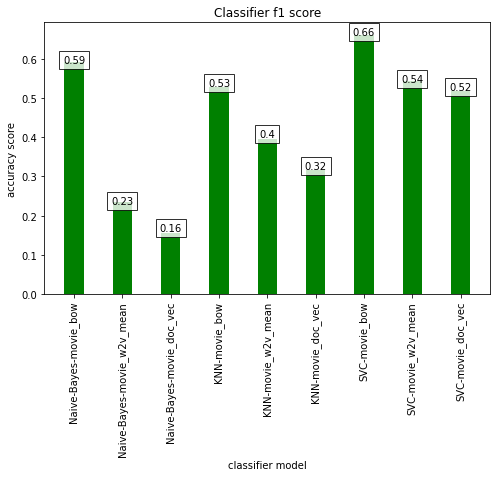

In [91]:
def valuelabel(x,y):
    y = round((y), 2)
    for i in range(len(x)):
        plt.text(i,y[i],y[i], ha = 'center',
                 bbox = dict(facecolor = 'white', alpha =0.8))
        
columns = ['Naive-Bayes-movie_bow','Naive-Bayes-movie_w2v_mean','Naive-Bayes-movie_doc_vec','KNN-movie_bow',
     'KNN-movie_w2v_mean','KNN-movie_doc_vec','SVC-movie_bow','SVC-movie_w2v_mean','SVC-movie_doc_vec']

plt.bar(x = columns, height = results_df['test_f1_score'], color = 'green', width = 0.4)
plt.title('Classifier f1 score')
plt.xticks(rotation = 90)
valuelabel(columns, results_df['test_f1_score'])
plt.xlabel('classifier model')
plt.ylabel('accuracy score')
plt.rcParams["figure.figsize"] = (8,5)
plt.show()

In [48]:
results_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, Naive-Bayes-movie_bow to SVC-movie_doc_vec
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   train_recall_score     9 non-null      float64
 1   test_recall_score      9 non-null      float64
 2   train_precision_score  9 non-null      float64
 3   test_precision_score   9 non-null      float64
 4   test_f1_score          9 non-null      float64
dtypes: float64(5)
memory usage: 732.0+ bytes


In [49]:
best_recall = results_df['test_recall_score'].idxmax()
best_precision = results_df['test_precision_score'].idxmax()

In [50]:
results_df.loc[results_df.index.isin([best_recall, best_precision])]

,train_recall_score,test_recall_score,train_precision_score,test_precision_score,test_f1_score
KNN-movie_bow,0.501606,0.433155,0.782519,0.675291,0.527776
SVC-movie_doc_vec,0.684718,0.677362,0.435649,0.418123,0.517069


Now that we have identified the top models based on precision as well as recall scores, we can take a closer look through the classification report.

In [24]:
print('Results: ', best_precision)
print(resultsDict[best_precision]['train_classification_report'])
print(resultsDict[best_precision]['test_classification_report'])

Results:  KNN-movie_bow
              precision    recall  f1-score   support

      Action       0.84      0.61      0.71       208
   Adventure       0.70      0.25      0.37       122
   Animation       1.00      0.25      0.40        32
   Biography       0.00      0.00      0.00         3
      Comedy       0.82      0.39      0.53       278
       Crime       0.71      0.39      0.50       156
       Drama       0.75      0.86      0.80       470
      Family       1.00      0.07      0.14        27
     Fantasy       0.90      0.12      0.22        73
   Film-Noir       0.00      0.00      0.00         2
     History       0.00      0.00      0.00         3
      Horror       0.96      0.38      0.55       115
       Music       0.00      0.00      0.00        25
     Mystery       1.00      0.07      0.13        83
     Romance       0.77      0.13      0.22       156
      Sci-Fi       0.85      0.43      0.57       110
       Sport       0.00      0.00      0.00         2
   

In [25]:
print('Results: ', best_recall)
print(resultsDict[best_recall]['train_classification_report'])
print(resultsDict[best_recall]['test_classification_report'])

Results:  SVC-movie_doc_vec
              precision    recall  f1-score   support

      Action       0.45      0.76      0.57       208
   Adventure       0.25      0.60      0.36       122
   Animation       1.00      0.03      0.06        32
   Biography       0.03      1.00      0.07         3
      Comedy       0.54      0.68      0.61       278
       Crime       0.27      0.76      0.39       156
       Drama       0.70      0.64      0.67       470
      Family       0.08      0.70      0.14        27
     Fantasy       0.14      0.64      0.23        73
   Film-Noir       0.22      1.00      0.36         2
     History       0.14      1.00      0.24         3
      Horror       0.26      0.80      0.39       115
       Music       0.11      0.32      0.16        25
     Mystery       0.10      1.00      0.18        83
     Romance       0.32      0.64      0.43       156
      Sci-Fi       0.25      0.75      0.38       110
       Sport       0.10      1.00      0.17         2

In [26]:
resultsDict[best_precision]['fitted_model']

OneVsRestClassifier(estimator=GridSearchCV(estimator=KNeighborsClassifier(),
                                           param_grid={'n_neighbors': [4, 5, 7,
                                                                       9]},
                                           scoring=make_scorer(f1_score, average=micro)))

# Subsetting

Subsetting on the data source:

In [27]:
predictor_results = {}
for group in ['bow', 'w2v', 'doc_vec']:
    subset = results_df.filter(like=group, axis=0)

    predictor_results[group] = {'min_test_precision': subset['test_precision_score'].min(),
                                'max_test_precision': subset['test_precision_score'].max(),
                                'mean_test_precision':subset['test_precision_score'].mean(),
                                'min_test_recall': subset['test_recall_score'].min(),
                                'max_test_recall': subset['test_recall_score'].max(),
                                'mean_test_recall':subset['test_recall_score'].mean()}

In [28]:
column_order = ['min_test_precision','max_test_precision','mean_test_precision',
                                            'min_test_recall','max_test_recall','mean_test_recall']

pd.DataFrame(predictor_results).transpose()[column_order]

,min_test_precision,max_test_precision,mean_test_precision,min_test_recall,max_test_recall,mean_test_recall
bow,0.668107,0.675291,0.671303,0.433155,0.650624,0.538324
w2v,0.260032,0.545837,0.428438,0.213904,0.629234,0.384433
doc_vec,0.122231,0.418123,0.306503,0.213904,0.677362,0.387998


Bag of words(TFIDF) has the best performance with regard to precision, whereas doc2vec has the best performance with regard to recall. Word2vec has by far the lowest performance of the three.(in what instances) Word2vec analyzes the plots on a word-by-word basis, whereas Doc2vec analyzes the entire plot as a single vector.